# Рекомендация тарифов

<div class="alert alert-info">
Привет! Меня зовут Никита Мишин и я буду твоим ревьюером по этому проекты.
Для простоты предлагаю общение на 'ты'. Буду предполагать, что ты не против:) 
Если более предпочтительно обращение на 'Вы', пиши, не стесняйся.
Также если будут возникать вопросы, аналогично, пиши:)

Предлагаю работать в известном тебе итеративном формате.
Итерация состоит в моей проверке твоего решения. 
После решения могут остаться какие-то недочеты, которые я попрошу тебя устранить, ты их исправляешь и я проверяю твои решения.
    Оставленные мною комментарии могут быть разного вида:
   
    - зеленый: элегантные решения, которые тебе стоит запомнит и в дальнейшем взять на вооружение:) 
    
    - желтый: сигнал о том, что есть некритичная вещь(не всегда ошибка), что нужно точно поправить в следующей работе, даже желательно в этой (полезно, в первую очередь, для тебя:) ).Также это рекомендации на будущее    

    - красный: недочет, который нужно исправить в этой работе, для того, чтобы она была принята
    
    - синий: полезная информация, доп ресурсы, "вопросы на подумать"

Также попрошу не удалять мои комментарии:) <a class="tocSkip">
</div>

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков,<br/>
- minutes — суммарная длительность звонков в минутах,<br/>
- messages — количество sms-сообщений,<br/>
- mb_used — израсходованный интернет-трафик в Мб,<br/>
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Для начала - немного подготовимся

In [1]:
import pandas as pd
import itertools as it
import json
import time
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

pd.options.display.max_colwidth = 999
warnings.filterwarnings('ignore')

<div class="alert alert-warning">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Зачем тебе json?
</div>

<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
    Молодец, что группируешь все импорты в одном месте, такая структуризации полезна и удобна

</div>

In [2]:
GLOBAL_RANDOM_STATE = 12345 # единое для всех процессов, задействующих psr-генератор

class ClassificationModelEvaluator:
    """
        Общий класс для типового процесса тестирования гиперпараметров модели
        Используем все возможные перестановки параметров для передачи их в рамках обучения
        Выбираем лучшую перестановку по результирующему score; если таких несколько - то с минимальным временем обучения
        теоретически, нужен еще и tiebreaker при равенстве score и fit time, но "я подумаю об этом завтра" aka TO-DO.
        Забавно, что как показали дальнейшие исследования,  реализованный мной вариант GridSearchCV, явно менее производительный,
        но решающий задачу в удобной для меня форме, причем, на удивление, фактически с той же логикой параметризации 
    """
    def __init__(self, classifier: object):
        self.classifier = classifier
    def set_hparams_ranges(self, model_params_range: dict) -> None:
        self.model_params_range = model_params_range
        
    def predict(self, feat: pd.DataFrame) -> pd.Series:
        return pd.Series(self.best_model.predict(feat))
        
    def score_model(self, feat: pd.DataFrame, targ: pd.Series) -> pd.DataFrame:
        start_time = time.perf_counter()
        score = self.best_model.score(feat, targ)
        end_time = time.perf_counter()
        result = pd.DataFrame(columns=['classifier','params','score','score_time_sec'])
        result.loc[len(result)] = data=[self.classifier.__class__.__name__, dict(self.best_params), score, end_time-start_time]
        return result
    
    def hparams_evaluation(self, 
        feat_train: pd.DataFrame, 
        targ_train: pd.Series,
        feat_valid: pd.DataFrame,
        targ_valid: pd.Series,
        return_only_optimal = True
                ) -> pd.DataFrame:
        param_names, param_values, counter = {}, [], 0
        for key, value in self.model_params_range.items():
            param_names[key] = counter
            param_values.append(value)
            counter += 1            
        params = {}
        result = pd.DataFrame(columns=['classifier','params','score','fit_time_sec'])
        max_score, min_time = 0, 99999999999
        # перебираем все комбинации параметров и обучаем под каждую комбинацию модель, сохраняя результаты
        for p in it.product(*param_values):
            for pn, pi in param_names.items():
                params[pn] = p[pi]
            try: 
                self.classifier.set_params(**params)
                start_time = time.perf_counter()
                model = self.classifier.fit(feat_train, targ_train)
                fit_time = time.perf_counter() - start_time           
                score = model.score(feat_valid, targ_valid)
                if score > max_score:
                    max_score = score
                if fit_time < min_time:
                    min_time = fit_time
                result.loc[len(result)] = [self.classifier.__class__.__name__, dict(params), score, fit_time]
            except Exception as e:
                pass # некоторые параметры могут быть несовместимы
            
        result['best_score'] = result['score'] == max_score
        result['best_time'] = result['fit_time_sec'] == min_time
        best_score_time = result.query('best_score == True')['fit_time_sec'].min()
        result['best'] = result.apply(\
            lambda x: (x['fit_time_sec'] == best_score_time) & (x['score'] == max_score),\
            axis = 1)
        # обучаем и сохраняем модель с лучшими параметрами для дальнейшего использования 
        best_params = result.query('best == True')['params'].values[0]
        self.classifier.set_params(**best_params)
        self.best_model = self.classifier.fit(feat_train, targ_train)  
        self.best_params = dict(best_params)
        if return_only_optimal:
            return result.query('best == True')
        return result    
        

<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Классная идея оформить в виде класса и инкупсулировать всю логику по обучения и тестированию
</div>

In [3]:
# groupby + count по нужной колонке
def show_shares(data: pd.DataFrame, group_col: str, count_col: str) -> pd.DataFrame:
    return data[[group_col, count_col]]\
    .groupby(by=[group_col])\
    .agg('count')\
    .reset_index()\
    .rename(columns={count_col:'count'})\
    .assign(share = lambda x: x['count'] / data.shape[0])
    

In [4]:
# разбиение на выборки со стратификацией
def stratified_split(\
        features: pd.DataFrame,\
        target: pd.Series,\
        test_size: float = 0.4,\
        random_state: int = GLOBAL_RANDOM_STATE) -> list:
    return train_test_split(\
            features,\
            target,\
            test_size = test_size,\
            random_state = random_state,\
            shuffle=True,\
            stratify = target)

In [5]:
# построение графика-линии по одному и более серий
def line(series_name_x_y_dict, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    legend_list = []
    for name in series_name_x_y_dict:
        legend_list.append(name)
        ax.plot(
            series_name_x_y_dict[name]['x'],
            series_name_x_y_dict[name]['y'],
            linewidth=5
        )
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(title)        
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()
    plt.show()

In [6]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Аналогично лайк за то, что описал функции дабы не дублировать функциональность
</div>

## Откройте и изучите файл

In [7]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [8]:
data.sample(5)

,calls,minutes,messages,mb_used,is_ultra
257,23.0,188.32,62.0,21707.03,1
3060,42.0,277.25,49.0,15483.11,0
289,43.0,299.87,76.0,15787.74,1
512,118.0,796.32,3.0,17905.67,1
1085,94.0,713.46,15.0,22966.72,0


<div class="alert alert-warning">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
У sample лучше все же фиксировать рандом стэйт, чтобы была воспроизводимость (чтобы у меня и у тебя отображалось одно и тоже)
</div>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Все в порядке, никакх проблем не видно. На всякий случай, посмотрим на значения целевого признака:

In [10]:
show_shares(data, group_col='is_ultra', count_col='calls')

,is_ultra,count,share
0,0,2229,0.693528
1,1,985,0.306472


<div class="alert alert-info">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Еще полезно было бы вывести основные статистики датасета и проверить признаки на коллинеарность
</div>

При разбиении на выборки надо будет учесть сохранение соотношений для долей (стратификация)

## Разбейте данные на выборки

Сначала (60:40) для (тренировочной:валидация+тест)

In [11]:
target = data['is_ultra']
features = data.drop(['is_ultra'], axis=1)
feat_train, feat_valid_and_test, targ_train, targ_valid_and_test = stratified_split(features, target)


Убедимся, что соотношения сохранены для обеих выборок

In [12]:
show_shares(\
    feat_train.copy().assign(is_ultra = targ_train),\
    group_col='is_ultra',\
    count_col='calls')

,is_ultra,count,share
0,0,1337,0.693465
1,1,591,0.306535


In [13]:
show_shares(\
    feat_valid_and_test.copy().assign(is_ultra = targ_valid_and_test),\
    group_col='is_ultra',\
    count_col='calls')

,is_ultra,count,share
0,0,892,0.693624
1,1,394,0.306376


Хорошо, теперь разобъем 50:50 *_valid_and_test и убедимся что обе половины также стратифицированы:

In [14]:
feat_valid, feat_test, targ_valid, targ_test = stratified_split(\
            feat_valid_and_test, targ_valid_and_test, test_size = 0.5)

In [15]:
show_shares(\
    feat_valid.copy().assign(is_ultra = targ_valid),\
    group_col='is_ultra',\
    count_col='calls')

,is_ultra,count,share
0,0,446,0.693624
1,1,197,0.306376


In [16]:
show_shares(\
    feat_test.copy().assign(is_ultra = targ_test),\
    group_col='is_ultra',\
    count_col='calls')

,is_ultra,count,share
0,0,446,0.693624
1,1,197,0.306376


<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Молодец, данные разбиты на подвыборки верно, молодец!
</div>

## Исследуйте модели

Прогоним модели через оценку (в целях минимального изучения, не будет гонять dict-цикл по моделям с параметрами):

In [17]:
dtc = ClassificationModelEvaluator(DecisionTreeClassifier())
dtc.set_hparams_ranges(
    {
        "random_state": [12345],
        "max_depth": list(range(1,11)),
        "criterion": ['gini', 'entropy'],
        "splitter": ['best','random']
    } 
)
dtc_results = dtc.hparams_evaluation(feat_train, targ_train, feat_valid, targ_valid,return_only_optimal=False)
dtc_results

,classifier,params,score,fit_time_sec,best_score,best_time,best
0,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 1, 'criterion': 'gini', 'splitter': 'best'}",0.740280,0.002793,False,False,False
1,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 1, 'criterion': 'gini', 'splitter': 'random'}",0.693624,0.001840,False,False,False
2,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 1, 'criterion': 'entropy', 'splitter': 'best'}",0.740280,0.002611,False,False,False
3,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 1, 'criterion': 'entropy', 'splitter': 'random'}",0.693624,0.001720,False,False,False
4,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 2, 'criterion': 'gini', 'splitter': 'best'}",0.772939,0.002957,False,False,False
5,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 2, 'criterion': 'gini', 'splitter': 'random'}",0.712286,0.002031,False,False,False
6,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 2, 'criterion': 'entropy', 'splitter': 'best'}",0.772939,0.002982,False,False,False
7,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 2, 'criterion': 'entropy', 'splitter': 'random'}",0.712286,0.001643,False,True,False
8,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 3, 'criterion': 'gini', 'splitter': 'best'}",0.777605,0.003089,False,False,False
9,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 3, 'criterion': 'gini', 'splitter': 'random'}",0.726283,0.001672,False,False,False


<div class="alert alert-warning">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Ты ведь выше GLOBAL_RANDOM_STATE описал;)
</div>

Для дальнейшего упрощения свода, оставим только победителя:

In [18]:
dtc_leader = dtc_results.query('best == True')
leaders_df = dtc_leader.copy()
dtc_leader

,classifier,params,score,fit_time_sec,best_score,best_time,best
28,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 8, 'criterion': 'gini', 'splitter': 'best'}",0.802488,0.006193,True,False,True


Оцениваем RandomForest:

In [19]:
rfc = ClassificationModelEvaluator(RandomForestClassifier())
rfc.set_hparams_ranges(
    {
        "random_state": [12345],
        "n_estimators": list(range(1,11)),
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(1,11))        
    } 
)
rfc_results = rfc.hparams_evaluation(feat_train, targ_train, feat_valid, targ_valid,return_only_optimal=False)
rfc_results

,classifier,params,score,fit_time_sec,best_score,best_time,best
0,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 1}",0.748056,0.004276,False,False,False
1,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 2}",0.776050,0.004015,False,False,False
2,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 3}",0.776050,0.003710,False,False,False
3,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 4}",0.748056,0.004112,False,False,False
4,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 1, 'criterion': 'gini', 'max_depth': 5}",0.771384,0.005407,False,False,False
...,...,...,...,...,...,...,...
195,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 6}",0.780715,0.027355,False,False,False
196,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 7}",0.797823,0.029843,False,False,False
197,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 8}",0.802488,0.033436,False,False,False
198,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 9}",0.804044,0.035762,False,False,False


"...и лучшим лесом выбран ... самый быстрый из лучших лесов":

In [20]:
rfc_results.query('best_score == True')

,classifier,params,score,fit_time_sec,best_score,best_time,best
105,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 6, 'criterion': 'gini', 'max_depth': 6}",0.807154,0.014323,True,False,True
139,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 7, 'criterion': 'entropy', 'max_depth': 10}",0.807154,0.025126,True,False,False
159,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 8, 'criterion': 'entropy', 'max_depth': 10}",0.807154,0.029231,True,False,False


<div class="alert alert-info">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, неожиданно получилось
</div>

In [21]:
rfc_leader = rfc_results.query('best == True')
leaders_df = pd.concat([leaders_df, rfc_leader])
rfc_leader

,classifier,params,score,fit_time_sec,best_score,best_time,best
105,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 6, 'criterion': 'gini', 'max_depth': 6}",0.807154,0.014323,True,False,True


Оцениваем LogisticRegression:

In [22]:
lrc = ClassificationModelEvaluator(LogisticRegression())
lrc.set_hparams_ranges(
    {
        "random_state": [12345],
        "penalty": ['l1', 'l2', 'elasticnet', 'none'],
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "multi_class": ['auto', 'ovr', 'multinomial']
    } 
)
lrc_results = lrc.hparams_evaluation(feat_train, targ_train, feat_valid, targ_valid,return_only_optimal=False)
lrc_results

,classifier,params,score,fit_time_sec,best_score,best_time,best
0,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'auto'}",0.738725,0.012688,True,False,False
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.738725,0.011512,True,False,True
2,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'auto'}",0.693624,0.023816,False,False,False
3,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'ovr'}",0.693624,0.024454,False,False,False
4,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'multinomial'}",0.693624,0.036886,False,False,False
5,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'auto'}",0.738725,0.106042,True,False,False
6,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'ovr'}",0.738725,0.112308,True,False,False
7,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'multinomial'}",0.738725,0.323243,True,False,False
8,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'auto'}",0.738725,0.030538,True,False,False
9,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'ovr'}",0.738725,0.030189,True,False,False


Почти как в Эрмитаже - "бедненько, но чистенько" ... то есть "слабенько, но быстренько" (хотя, "наблюдаются варанты ..."):

In [23]:
lrc_results.query('best_score == True')

,classifier,params,score,fit_time_sec,best_score,best_time,best
0,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'auto'}",0.738725,0.012688,True,False,False
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.738725,0.011512,True,False,True
5,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'auto'}",0.738725,0.106042,True,False,False
6,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'ovr'}",0.738725,0.112308,True,False,False
7,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'multinomial'}",0.738725,0.323243,True,False,False
8,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'auto'}",0.738725,0.030538,True,False,False
9,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'ovr'}",0.738725,0.030189,True,False,False
19,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'auto'}",0.738725,0.161223,True,False,False
20,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'ovr'}",0.738725,0.122856,True,False,False
21,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'multinomial'}",0.738725,0.287759,True,False,False


In [24]:
lrc_leader = lrc_results.query('best == True')
leaders_df = pd.concat([leaders_df, lrc_leader])
lrc_leader

,classifier,params,score,fit_time_sec,best_score,best_time,best
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.738725,0.011512,True,False,True


<div class="alert alert-info">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Можно было бы попробовать взвешивание классов (balanced mode), мб лучше бы скор был
</div>

Не будем заставлять страдать классификатор на базе линейной регресии или гонять NN-based классификатор из sklearn (утомительно), посмотрим на классификатор на базе градиентного спуска.Небыстро (~6 минут), но интересно:

In [25]:
gbc = ClassificationModelEvaluator(GradientBoostingClassifier())
gbc.set_hparams_ranges(
    {
        "random_state": [12345],
        "n_estimators": list(range(30,50,5)),
        "loss": ['deviance', 'exponential'],
        "criterion": ['friedman_mse', 'mse', 'mae'],
        "max_depth": list(range(1,10))
    } 
)
gbc_results = gbc.hparams_evaluation(feat_train, targ_train, feat_valid, targ_valid,return_only_optimal=False)
gbc_results

,classifier,params,score,fit_time_sec,best_score,best_time,best
0,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 30, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 1}",0.780715,0.039209,False,False,False
1,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 30, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 2}",0.788491,0.067384,False,False,False
2,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 30, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3}",0.802488,0.078843,False,False,False
3,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 30, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 4}",0.810264,0.094377,False,False,False
4,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 30, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 5}",0.808709,0.129124,False,False,False
...,...,...,...,...,...,...,...
211,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'exponential', 'criterion': 'mae', 'max_depth': 5}",0.793157,3.447509,False,False,False
212,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'exponential', 'criterion': 'mae', 'max_depth': 6}",0.786936,3.912440,False,False,False
213,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'exponential', 'criterion': 'mae', 'max_depth': 7}",0.783826,4.477744,False,False,False
214,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'exponential', 'criterion': 'mae', 'max_depth': 8}",0.788491,4.615728,False,False,False


<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Классно, что опробовал на практике GBC классификатор
</div>

Кто же "лидеры умения находить путь по градиенту?"

In [26]:
gbc_results.query('best_score == True')

,classifier,params,score,fit_time_sec,best_score,best_time,best
57,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 35, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 4}",0.81804,0.126879,True,False,False
66,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 35, 'loss': 'deviance', 'criterion': 'mse', 'max_depth': 4}",0.81804,0.106664,True,False,False
164,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3}",0.81804,0.103717,True,False,True
173,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'deviance', 'criterion': 'mse', 'max_depth': 3}",0.81804,0.103948,True,False,False


In [27]:
gbc_leader = gbc_results.query('best == True')
leaders_df = pd.concat([leaders_df, gbc_leader])
gbc_leader

,classifier,params,score,fit_time_sec,best_score,best_time,best
164,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3}",0.81804,0.103717,True,False,True


Как зависит время обучения от max_depth и n_estimators (для лидера с loss = deviance и criterion = friedman_mse)? Практически никак:

In [28]:
# выборка данных, график - ячейкой ниже
def filter_gbc_results(x: pd.Series) -> pd.DataFrame:
    params = x['params']
    if params['loss'] == 'deviance' and params['criterion'] == 'friedman_mse':
        x['use'] = True
    else:
        x['use'] = False
    x['n_est'] = params['n_estimators']
    x['m_dep'] = params['max_depth']
    return x
    
ed2time = gbc_results.apply(filter_gbc_results, axis=1)\
    .query('use == True')[['fit_time_sec','n_est','m_dep','score']]

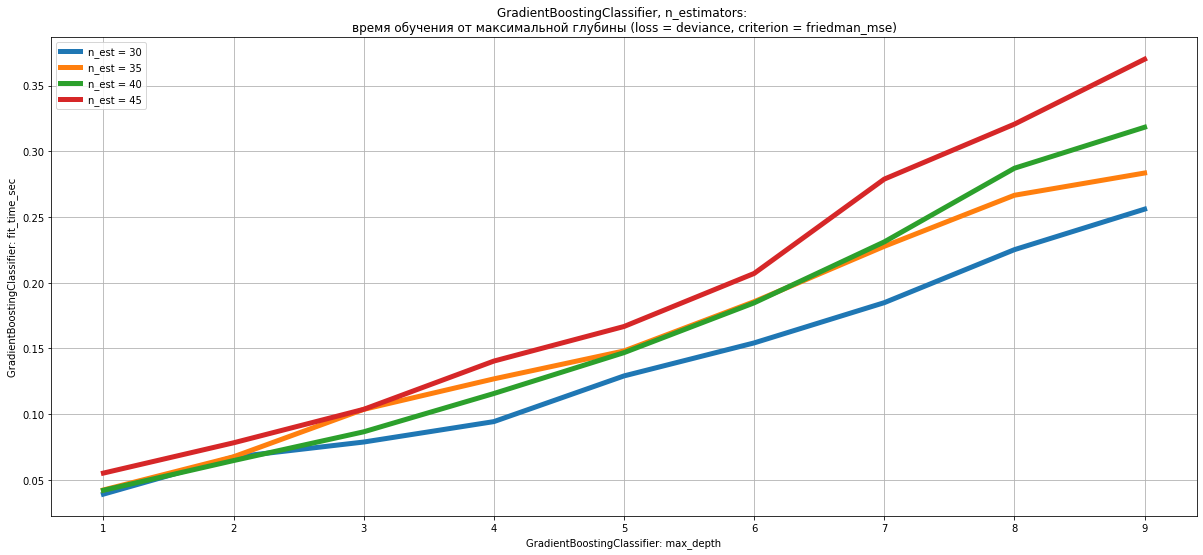

In [29]:
series_name_x_y_dict = {}
for line_badge in ed2time['n_est'].unique():
    series_name_x_y_dict['n_est = ' + str(line_badge)] = {
        'x': ed2time.query('n_est == @line_badge').sort_values(by='m_dep')['m_dep'],
        'y': ed2time.query('n_est == @line_badge').sort_values(by='m_dep')['fit_time_sec'],
    }   
line(
    series_name_x_y_dict, 
    xlab='GradientBoostingClassifier: max_depth',
    ylab='GradientBoostingClassifier: fit_time_sec', 
    title='GradientBoostingClassifier, \
n_estimators: \nвремя обучения от максимальной глубины (loss = deviance, criterion = friedman_mse)', 
    figsize=(17,8), 
    fontsize=16)

<div class="alert alert-info">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Небольшое замечания:
    
    1)насчет языка: лучше чтобы соблюдалось языковое единообразие.
        
    2) Стоит поставить min,max у xticks соответственно 1 и 9
</div>

Как зависит точность от max_depth и n_estimators (для лидера с loss = deviance и criterion = friedman_mse)? Практически сразу вышли на пик (max_depth = 3), дальше можно было уже и не пробовать

    

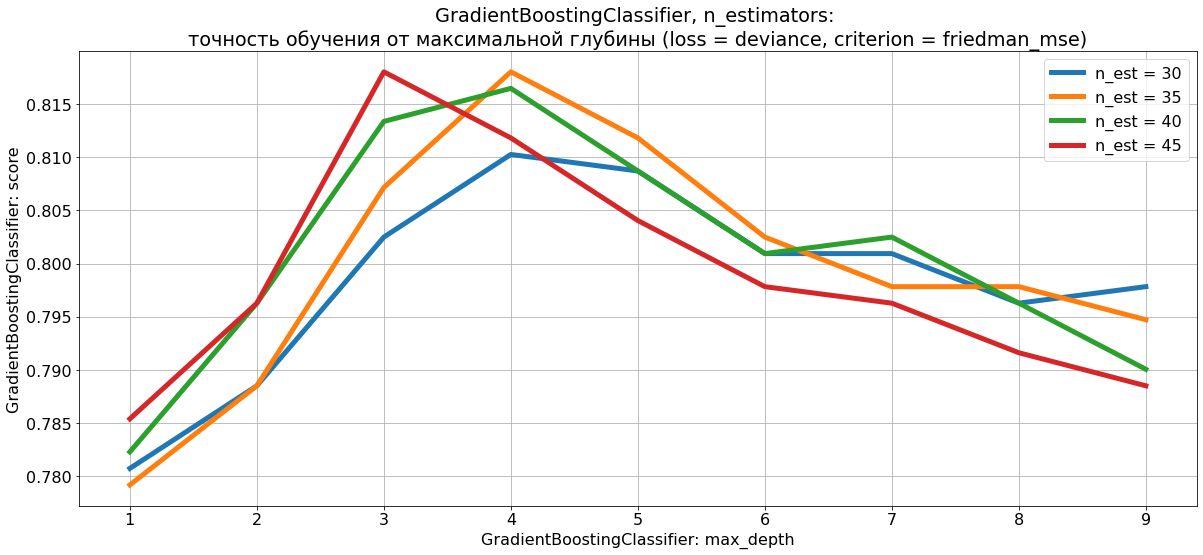

In [30]:
series_name_x_y_dict = {}
for line_badge in ed2time['n_est'].unique():
    series_name_x_y_dict['n_est = ' + str(line_badge)] = {
        'x': ed2time.query('n_est == @line_badge').sort_values(by='m_dep')['m_dep'],
        'y': ed2time.query('n_est == @line_badge').sort_values(by='m_dep')['score'],
    }   
line(
    series_name_x_y_dict, 
    xlab='GradientBoostingClassifier: max_depth',
    ylab='GradientBoostingClassifier: score', 
    title='GradientBoostingClassifier, \
n_estimators: \nточность обучения от максимальной глубины (loss = deviance, criterion = friedman_mse)', 
    figsize=(17,8), 
    fontsize=16)

Взгляем на итог:

In [31]:
leaders_df.sort_values(by=['score','fit_time_sec'], ascending=False).drop(columns=['best_score','best_time','best'])

,classifier,params,score,fit_time_sec
164,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3}",0.818040,0.103717
105,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 6, 'criterion': 'gini', 'max_depth': 6}",0.807154,0.014323
28,DecisionTreeClassifier,"{'random_state': 12345, 'max_depth': 8, 'criterion': 'gini', 'splitter': 'best'}",0.802488,0.006193
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.738725,0.011512


Ожидаемо, по качеству лучше всех GradientBoostingClassifier, а по времени (но увы, не подходит под условия задачи) - LogisticRegression.

<div class="alert alert-success">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Молодец, хорошее решение, радует детальный анализ влияния гиперпараметров на скор моделей.
Лайк отдельный за табличку сводную:)
</div>

## Проверьте модель на тестовой выборке

Воспользуемся лучшей моделью:

In [32]:
gbc.score_model(feat_test, targ_test)

,classifier,params,score,score_time_sec
0,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 45, 'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3}",0.807154,0.003167


<div class="alert alert-info">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Бейзлайн уверенно побит, поздравляю!
</div>

Чуть ниже, чем при валидации, но условиям задачи удовлетворяет

## (бонус) Проверьте модели на адекватность

Можно помучаться и сгенерировать рандомный Series, который бы сохранял пропорции target и сравнить с ним, но сделаем тривильное 
предположение, что "неадекватная модель не сумеет даже пропоцию соблюсти на тестовой выборке" и, исходя из этого, просто посмотрим на результаты лучшей и худшей модели:

<div class="alert alert-warning">

<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Ты, видимо, не совсем верно понял, что такое проверка на неадекватность.

На пример, возьмем модель, которая предсказывает всегда наибольший класс. Тогда у нее точность будет 70 процентов для нашего случая.

Адекватность подразумевает, что твои обученные модели будут работать лучше (скор больше 70 процентов), чем дамми модели (как описанные выше). То есть модели действительно чему-то обучились и нашли какую-то скрытую зависимость.
    
    
По твоим рассуждениям модель, у которой будет точность 90, но соотношение классов она не сохранится, не будет 'адекватной', а модель с точность 40 или 50, но которая сохраняет пропорции в классах --- 'адекватная'. :)
</div>

In [33]:
adeq = pd.DataFrame(columns=['is_ultra_test', 'is_ultra_pred_best','is_ultra_pred_worst'])
adeq['is_ultra_test'] = targ_test.to_frame().reset_index()['is_ultra']
adeq['is_ultra_pred_best'] = gbc.predict(feat_test)
adeq['is_ultra_pred_worst'] = lrc.predict(feat_test)

Доли признаков в тестовой выборке:

In [34]:
show_shares(adeq, group_col='is_ultra_test', count_col='is_ultra_pred_best')           

,is_ultra_test,count,share
0,0,446,0.693624
1,1,197,0.306376


Доли признаков в предсказанной выборке для лучшей модели:

In [35]:
show_shares(adeq, group_col='is_ultra_pred_best', count_col='is_ultra_test')           

,is_ultra_pred_best,count,share
0,0,502,0.780715
1,1,141,0.219285


Доли признаков в предсказанной выборке для худшей модели:

In [36]:
show_shares(adeq, group_col='is_ultra_pred_worst', count_col='is_ultra_test')           

,is_ultra_pred_worst,count,share
0,0,593,0.92224
1,1,50,0.07776


Даже модель на базе градиентного бустинга нельзя назвать адекватной, а уж на базе логистической регрессии - и подавно.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

-Спасибо за качественно сделанный проект, было приятно проверять. 

- Видно, что приложено много усилий

- Код написан хорошо, компактно, понятно 

- Соблюдена структура проекта 
    
- Также оставил пару замечаний и советов

Желаю успехов в дальейших проектах! Удачи!
</div>

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
